In [1]:
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x



In [6]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

In [7]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x



In [8]:

class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


In [9]:
class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


In [10]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# ----- Attention U-Net -----
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottom = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.att4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.att3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.att2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.att1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.conv1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)

        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        d3 = self.down3(p2)
        p3 = self.pool3(d3)

        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        bottom = self.bottom(p4)

        up4 = self.up4(bottom)
        att4 = self.att4(g=up4, x=d4)
        up4 = torch.cat([att4, up4], dim=1)
        up4 = self.conv4(up4)

        up3 = self.up3(up4)
        att3 = self.att3(g=up3, x=d3)
        up3 = torch.cat([att3, up3], dim=1)
        up3 = self.conv3(up3)

        up2 = self.up2(up3)
        att2 = self.att2(g=up2, x=d2)
        up2 = torch.cat([att2, up2], dim=1)
        up2 = self.conv2(up2)

        up1 = self.up1(up2)
        att1 = self.att1(g=up1, x=d1)
        up1 = torch.cat([att1, up1], dim=1)
        up1 = self.conv1(up1)

        return torch.sigmoid(self.final(up1))

In [11]:

# class Unet(nn.Module):

#  def __init__(self, in_channels, classes, first_out_channels=64):
#   super(Unet, self).__init__()
#   self.n_channels = in_channels
#   self.n_classes =  classes
#   self.nc = first_out_channels
#   self.nc2 = 2 * self.nc
#   self.nc4 = 4 * self.nc
#   self.nc8 = 8 * self.nc

#   self.inc = InConv(in_channels, self.nc)
#   self.down1 = Down(self.nc, self.nc2)
#   self.down2 = Down(self.nc2, self.nc4)
#   self.down3 = Down(self.nc4, self.nc8)
#   self.down4 = Down(self.nc8, self.nc8)
#   self.up1 = Up(2*self.nc8, self.nc4)
#   self.up2 = Up(self.nc8, self.nc2)
#   self.up3 = Up(self.nc4, self.nc)
#   self.up4 = Up(self.nc2, self.nc)
#   self.outc = OutConv(self.nc, classes)

#  def forward(self, x):
#   x1 = self.inc(x)
#   x2 = self.down1(x1)
#   x3 = self.down2(x2)
#   x4 = self.down3(x3)
#   x5 = self.down4(x4)
#   x = self.up1(x5, x4)
#   x = self.up2(x, x3)
#   x = self.up3(x, x2)
#   x = self.up4(x, x1)
#   x = self.outc(x)
#   return nn.Sigmoid()(x)


In [12]:

# UNet model creation:
net = AttentionUNet(3, 1).to(device)

In [13]:
import copy
import cv2
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from torchinfo import summary

import torchvision
import torchvision.transforms as transforms
import torchvision.utils

from zipfile import ZipFile



In [14]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
use_pre_trained = False # True - load the model already trained and saved, False - train the model
"""
When save_input_classes = True and save_train_test_splitting = True,
the initial splitting of the data into training and test sets is performed.
"""
save_input_classes = True
save_train_test_splitting = True

In [26]:
DATA_PATH = '/content/gdrive/MyDrive/'
CURR_PATH = '/content/gdrive/MyDrive/Colab Notebooks/'

FILE_NAME = CURR_PATH + 'model_seg_pytorch_medicalunet.cnn'   # to save the model check-points during the training
FILE_NAME_PR = CURR_PATH + 'model_seg_pytorch_medicalunet.cnn_23' # the pre-trained model

r_size = 256
batch_size = 8
ep_num = 10

zip_name = 'ISSBI2015.zip'

In [17]:
with ZipFile(DATA_PATH + zip_name, 'r') as f:
    names = f.namelist()

len(names), names[10]

(7608, 'ISSBI2015/training1/training01_01_flair_pp_slice_101+mask.tiff')

In [18]:
names = [n.split('/')[-1] for n in names]
names = list(filter(lambda x: (x != '' and x != 'data.csv' and x != 'README.md'), names))
names[0], len(names)

('training01_01_flair_pp_slice_0+mask.tiff', 7602)

In [19]:
f_names = [ 'ISSBI2015/' + n[:8]+n[9] + '/' + n for n in names]
f_names[0]

'ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff'

In [20]:
f_images = list(filter(lambda x: 'mask' not in x, f_names))
f_images[0], len(f_images)

('ISSBI2015/training1/training01_01_flair_pp_slice_0.tiff', 3801)

In [21]:
f_masks = list(filter(lambda x: 'mask' in x, f_names))
f_masks[0], len(f_masks)

('ISSBI2015/training1/training01_01_flair_pp_slice_0+mask.tiff', 3801)

In [22]:
del f_names
del f_masks

In [23]:
def show_input_sample(f_images):
    random.shuffle(f_images)
    with ZipFile(DATA_PATH + zip_name) as archive:
        data = archive.read(f_images[0])
        print(f_images[0][:-5] + '+mask.tiff')
        data1 = archive.read(f_images[0][:-5] + '+mask.tiff')

    img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    print(mask.max(), mask.min(), np.unique(mask))

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    axes[0].imshow(img)
    axes[1].imshow(mask)
    plt.show()

ISSBI2015/training4/training04_03_flair_pp_slice_60+mask.tiff
0 0 [0]


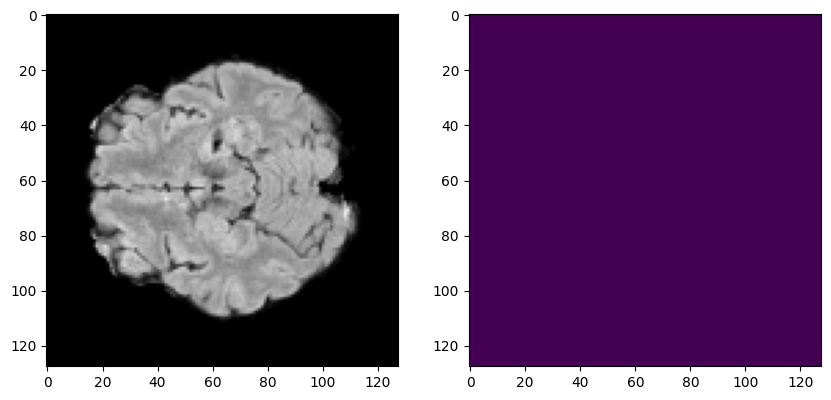

In [24]:
show_input_sample(f_images)

In [27]:
if save_input_classes:
    f_images0 = []
    f_images1 = []

    for f in f_images:
        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(f)
            print(f[:-5] + '+mask.tiff')
            data1 = archive.read(f[:-5] + '+mask.tiff')

            mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      #      print(mask.max(),mask.min(),np.unique(mask))
            if mask.max() < 127:
                f_images0.append(f)
            else:
                f_images1.append(f)

    with open(DATA_PATH + "fN_im0.txt", "w") as fl:
        for f in f_images0:
            fl.write(f + '\n')

    with open(DATA_PATH + "fN_im1.txt", "w") as fl:
        for f in f_images1:
            fl.write(f + '\n')

ISSBI2015/training4/training04_03_flair_pp_slice_60+mask.tiff
ISSBI2015/training3/training03_01_flair_pp_slice_89+mask.tiff
ISSBI2015/training4/training04_01_flair_pp_slice_61+mask.tiff
ISSBI2015/training1/training01_01_flair_pp_slice_86+mask.tiff
ISSBI2015/training3/training03_05_flair_pp_slice_118+mask.tiff
ISSBI2015/training5/training05_03_flair_pp_slice_145+mask.tiff
ISSBI2015/training3/training03_04_flair_pp_slice_126+mask.tiff
ISSBI2015/training2/training02_01_flair_pp_slice_175+mask.tiff
ISSBI2015/training2/training02_02_flair_pp_slice_70+mask.tiff
ISSBI2015/training1/training01_02_flair_pp_slice_21+mask.tiff
ISSBI2015/training5/training05_01_flair_pp_slice_52+mask.tiff
ISSBI2015/training1/training01_04_flair_pp_slice_111+mask.tiff
ISSBI2015/training4/training04_02_flair_pp_slice_134+mask.tiff
ISSBI2015/training1/training01_04_flair_pp_slice_52+mask.tiff
ISSBI2015/training2/training02_03_flair_pp_slice_172+mask.tiff
ISSBI2015/training5/training05_02_flair_pp_slice_120+mask.tiff


In [28]:
with open(DATA_PATH + "fN_im0.txt", "r") as fl:
    f_images0 = fl.readlines()

f_images0 = [f.strip() for f in f_images0]

with open(DATA_PATH + "fN_im1.txt", "r") as fl:
    f_images1 = fl.readlines()

f_images1 = [f.strip() for f in f_images1]

In [29]:
len(f_images0), len(f_images1)

(2236, 1565)

ISSBI2015/training3/training03_04_flair_pp_slice_82+mask.tiff
255 0 [  0 255]


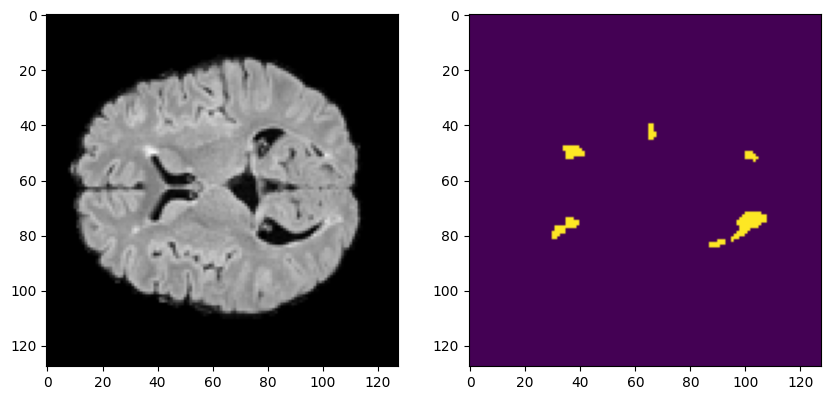

In [30]:
show_input_sample(f_images1)

ISSBI2015/training3/training03_05_flair_pp_slice_32+mask.tiff
0 0 [0]


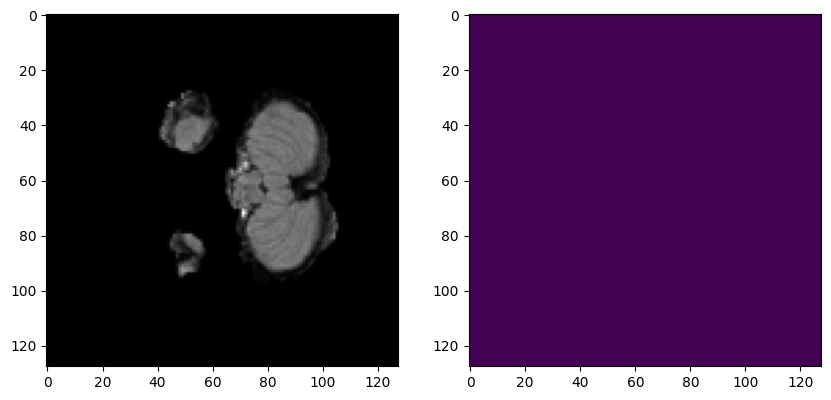

In [31]:
show_input_sample(f_images0)

In [32]:
if save_train_test_splitting:
    random.shuffle(f_images0)
    train_len0 = int(0.9 * len(f_images0))
    df_train0 = f_images0[:train_len0]
    df_test0 = f_images0[train_len0:]

    random.shuffle(f_images1)
    train_len1 = int(0.9 * len(f_images1))
    df_train1 = f_images1[:train_len1]
    df_test1 = f_images1[train_len1:]

    #To make a balanced training dataset:

    diff = len(df_train0) - len(df_train1)
    random.shuffle(df_train1)
    df_train1.extend(df_train1[:diff])

    df_train = df_train0
    df_test = df_test0

    df_train.extend(df_train1)
    df_test.extend(df_test1)

    with open(DATA_PATH + 'dfN_train.txt', 'w') as fl:
        for f in df_train0:
            fl.write(f + '\n')

    with open(DATA_PATH + 'dfN_test.txt', 'w') as fl:
        for f in df_test0:
            fl.write(f + '\n')

In [33]:
with open(DATA_PATH + 'dfN_train.txt', 'r') as fl:
    df_train = fl.readlines()
df_train = [f.strip() for f in df_train]

with open(DATA_PATH + 'dfN_test.txt', 'r') as fl:
    df_test = fl.readlines()
df_test = [f.strip() for f in df_test]

print(len(df_train))
print(len(df_test))

4024
381


In [34]:
# just to verify that the test data is not included in the training set
for dl in df_test:
    if dl in df_train:
        print('test line in the train set!!!')

In [35]:
class SegmentDataset(Dataset):
    def __init__(self,
                 gen_df,
                 transform=transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((r_size, r_size)),
                    transforms.ToTensor()
                 ]),
                 mask_color='GRAY'):
        self.gen_df = gen_df
        self.transform = transform
        self.mask_color = mask_color

    def __getitem__(self, index):
        img_name = self.gen_df[index]

        with ZipFile(DATA_PATH + zip_name) as archive:
            data = archive.read(img_name)
            data1 = archive.read(img_name[:-5] + '+mask.tiff')

        img = cv2.imdecode(np.frombuffer(data, np.uint8), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imdecode(np.frombuffer(data1, np.uint8), 1)
        if self.mask_color == 'GRAY':
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # اعمال تبدیل‌ها
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        # اگر ماسک خاکستری است، کانال‌های اضافی حذف شود
        if self.mask_color == 'GRAY' and mask.ndim == 3:
            mask = mask[0, :, :]

        return img, mask




        # if self.mask_color == 'GRAY':
        #     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        # else:
        #     mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # img_in = self.transform(img)
        # mask = self.transform(mask)

        #img = Image.fromarray(img)
       # img = image_processor(images=img, return_tensors="pt")

        # x = model_seg.embeddings(**img.to(device))
        # input_dimensions=x[1]
        # img0 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[0](x[0], input_dimensions=input_dimensions)
        # img1 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[1](x[0], input_dimensions=(input_dimensions[0]//2, input_dimensions[1]//2) )
        # img2 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[2](x[0], input_dimensions=(input_dimensions[0]//4, input_dimensions[1]//4) )
        # img3 = x[0].detach().squeeze(0)

        # x = model_seg.encoder.layers[3](x[0], input_dimensions=(input_dimensions[0]//8, input_dimensions[1]//8) )
        # x = model_seg.layernorm(x[0])
        # img4 = x.detach().squeeze(0)

        # return img, mask, img_in

    def __len__(self):
        return len(self.gen_df)

In [36]:
try_dataset = SegmentDataset(df_train, mask_color='RGB')

try_dataloader = DataLoader(try_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=2)
dataiter = iter(try_dataloader)

torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])


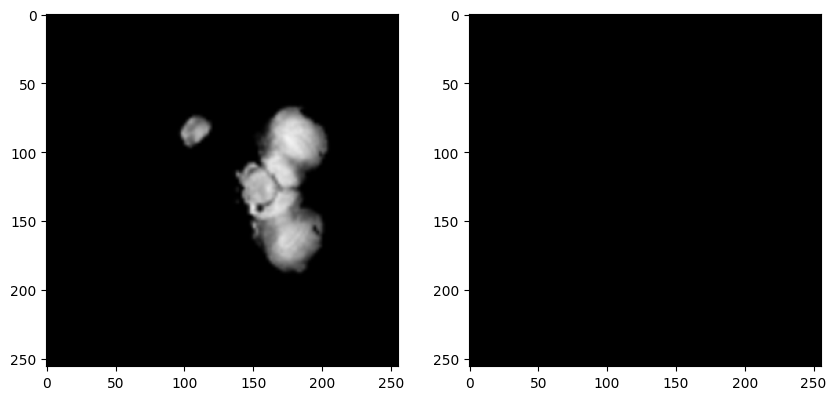

In [37]:
i ,m = next(dataiter)

print(i.shape, m.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(i[0].permute(1, 2, 0))  # تصویر
axes[1].imshow(m[0][0], cmap='gray')  # ماسک
plt.show()

In [38]:
del try_dataloader
del try_dataset
#del concatenated
#del c_img

In [39]:
train_dataset = SegmentDataset(df_train, mask_color='GRAY')

In [40]:
train_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=batch_size)

#net = MRI_Seg().to(device)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = optim.Adam(net.parameters(), lr=lr)

In [41]:
len(train_dataloader)

503

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


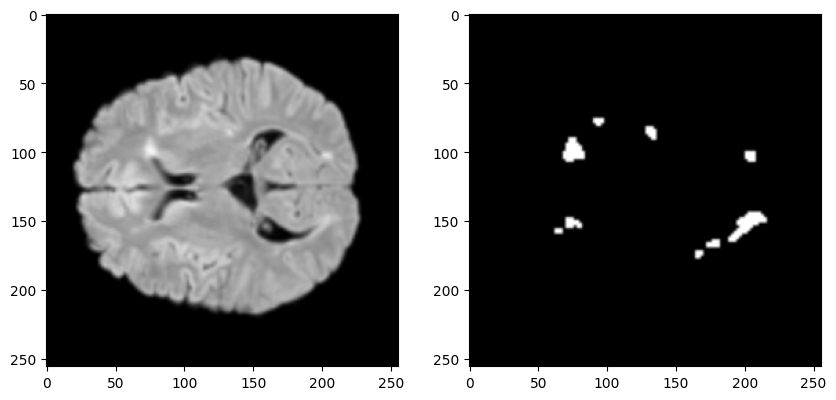

In [42]:
dataiter = iter(train_dataloader)




i ,m = next(dataiter)

print(i.shape, m.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
axes[0].imshow(i[0].permute(1, 2, 0))  # تصویر
axes[1].imshow(m[0], cmap='gray')  # ماسک
plt.show()

In [43]:
import torch.nn.functional as F


In [44]:
summary(model=net, input_size=(1, 3, 256, 256), col_names=['input_size', 'output_size', 'num_params', 'trainable'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
AttentionUNet                            [1, 3, 256, 256]          [1, 1, 256, 256]          --                        True
├─DoubleConv: 1-1                        [1, 3, 256, 256]          [1, 64, 256, 256]         --                        True
│    └─Sequential: 2-1                   [1, 3, 256, 256]          [1, 64, 256, 256]         --                        True
│    │    └─Conv2d: 3-1                  [1, 3, 256, 256]          [1, 64, 256, 256]         1,792                     True
│    │    └─BatchNorm2d: 3-2             [1, 64, 256, 256]         [1, 64, 256, 256]         128                       True
│    │    └─ReLU: 3-3                    [1, 64, 256, 256]         [1, 64, 256, 256]         --                        --
│    │    └─Conv2d: 3-4                  [1, 64, 256, 256]         [1, 64, 256, 256]         36,928                    True
│    

In [45]:
net.eval().to(device)

AttentionUNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

Output shape: torch.Size([8, 1, 256, 256])
Target shape: torch.Size([8, 1, 256, 256])
Max value in target: 1.0
Loss: 0.7441198825836182


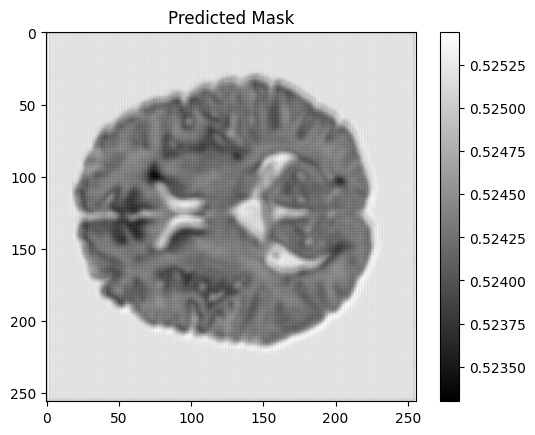

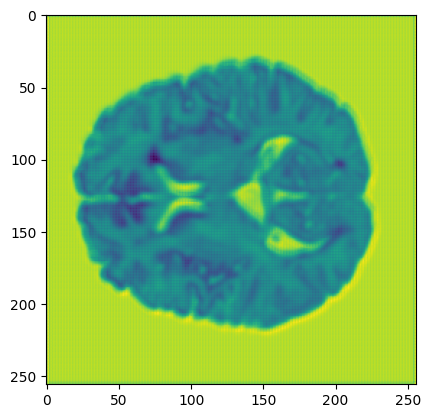

In [46]:
inputs = i.to(device)  # تصاویر ورودی
targets = m.to(device)  # ماسک‌ها
out = net(inputs)
targets = targets.unsqueeze(1)
print("Output shape:", out.shape)
print("Target shape:", targets.shape)

# بررسی حداکثر مقدار ماسک هدف
print("Max value in target:", targets.max().item())
# محاسبه Loss
ls = criterion(out, targets)
print("Loss:", ls.item())


#ls = criterion(out[0], Variable(y[0]).to(device))

#print(ls)

plt.imshow(out[0].cpu().detach().numpy()[0], cmap='gray')
plt.title("Predicted Mask")
plt.colorbar()
plt.show()
plt.imshow(out[0].cpu().detach().numpy()[0])
del out

In [47]:
def train_net():
    num_iter = len(train_dataloader)
    ep_init = 0

    for epoch in range(ep_init, ep_num):
        sum_loss = 0
        print(f"Epoch number: {epoch}")

        for i, data in enumerate(train_dataloader, 0):
            # Extract input tensors from data
            inputs, targets = data

            # Move data to device
            inputs = inputs.to(device)
            targets = targets.unsqueeze(1).to(device)  # Ensure target has the same shape as output

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)

            # Compute the loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate loss for reporting
            sum_loss += loss.item()

            # Print progress every 10 iterations
            if i % 10 == 0:
                avg_loss = sum_loss / (i + 1)
                print(f"Iteration {i}, Average Loss: {avg_loss:.6f}")
        torch.cuda.empty_cache()

        # Print epoch statistics
        avg_loss_epoch = sum_loss / num_iter
        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Num Iterations: {num_iter}, Learning Rate: {lr}, Average Loss: {avg_loss_epoch:.6f}")

        # Save model checkpoint
        torch.save(net, FILE_NAME + '_{}'.format(epoch + 1))
    # Save final model
    torch.save(net, FILE_NAME)
    print("Training complete. The model has been saved.")


In [48]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


In [49]:
if use_pre_trained is False:
    net.train().to(device)
    train_net()

Epoch number: 0
Iteration 0, Average Loss: 0.681955
Iteration 10, Average Loss: 0.572925
Iteration 20, Average Loss: 0.518103
Iteration 30, Average Loss: 0.484244
Iteration 40, Average Loss: 0.457045
Iteration 50, Average Loss: 0.436416
Iteration 60, Average Loss: 0.418457
Iteration 70, Average Loss: 0.403151
Iteration 80, Average Loss: 0.390822
Iteration 90, Average Loss: 0.380780
Iteration 100, Average Loss: 0.372441
Iteration 110, Average Loss: 0.365641
Iteration 120, Average Loss: 0.359246
Iteration 130, Average Loss: 0.353053
Iteration 140, Average Loss: 0.347203
Iteration 150, Average Loss: 0.341425
Iteration 160, Average Loss: 0.336328
Iteration 170, Average Loss: 0.331340
Iteration 180, Average Loss: 0.326629
Iteration 190, Average Loss: 0.322043
Iteration 200, Average Loss: 0.317707
Iteration 210, Average Loss: 0.313697
Iteration 220, Average Loss: 0.309771
Iteration 230, Average Loss: 0.306048
Iteration 240, Average Loss: 0.302650
Iteration 250, Average Loss: 0.299455
Iterati

In [50]:
def calc_rect(img_mask):
    ind = np.argwhere(img_mask >= 0.5)
    if len(ind) == 0:
        return None, None
    top_y = min(ind[:,0])
    bottom_y = max(ind[:,0])
    top_x = min(ind[:,1])
    bottom_x = max(ind[:,1])
    return (top_x, top_y), (bottom_x, bottom_y)

def show_results(inputs, targets, net,device, im_id):
    inputs = inputs.to(device)
    pred = net(inputs)
    pr = pred[im_id].cpu().detach().numpy().squeeze()


    xim = copy.deepcopy(inputs[im_id].permute(1, 2, 0).cpu().detach().numpy())
    xim = (xim * 255).astype(np.uint8)  # تبدیل به uint8
    r_size = 256  # تعریف اندازه
    # just to transform numpy array to cv2 image:
    xim = cv2.resize(xim, (r_size, r_size))
    top_left, bottom_right = calc_rect(pr)
    if top_left is not None:
        cv2.rectangle(xim, top_left, bottom_right, (255, 0, 0), 2)
    print(targets.shape)
    print(pr.shape)
    print(xim.shape)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 15))
    axes[0].imshow(targets[im_id].cpu().detach().numpy(), cmap="gray")
    axes[0].set_title("Ground Truth")
    axes[1].imshow(pr > 0.5, cmap="gray")
    axes[1].set_title("Predicted Mask")

    axes[2].imshow(xim/255)
    axes[2].set_title("Input Image with Bounding Box")

    plt.show()

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

In [52]:
if use_pre_trained:
   # del net
    map_location=torch.device('cpu')
    net = torch.load(FILE_NAME_PR, map_location=torch.device('cpu'))
    print("The pre-trained model loaded")

In [53]:
net.eval().to(device)

AttentionUNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

In [54]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'




In [55]:
device = torch.device("cpu")
net.to(device)


AttentionUNet(
  (down1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)

In [56]:
print(i.shape)

torch.Size([8, 3, 256, 256])


In [57]:
print(m.shape)

torch.Size([8, 256, 256])


torch.Size([8, 256, 256])
(256, 256)
(256, 256, 3)


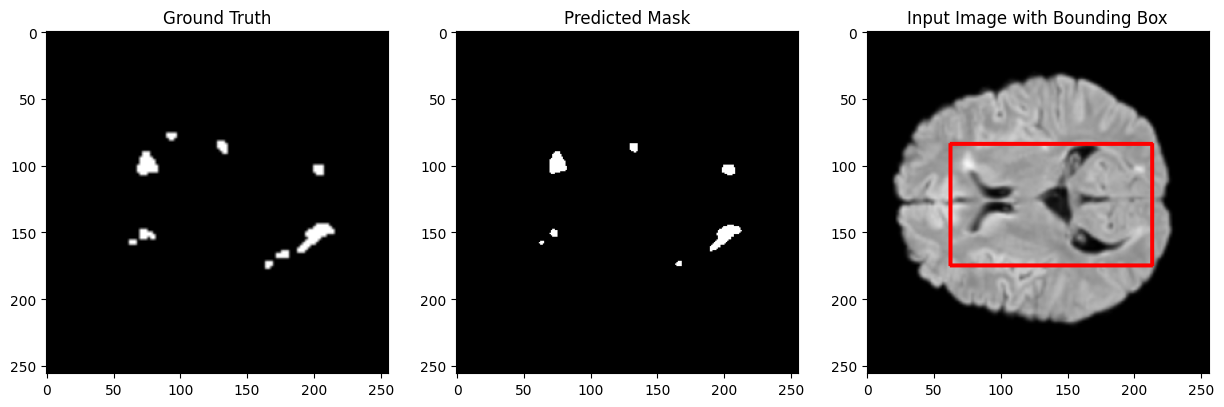

In [58]:
show_results(i,m,net,device, 0)

In [59]:
test_dataloader1 = DataLoader(train_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=1)

test_dataset = SegmentDataset(df_test)
test_dataloader2 = DataLoader(test_dataset,
                        shuffle=False,
                        num_workers=0,
                        batch_size=1)

In [60]:
dataiter = iter(test_dataloader1)

torch.Size([1, 256, 256])
(256, 256)
(256, 256, 3)


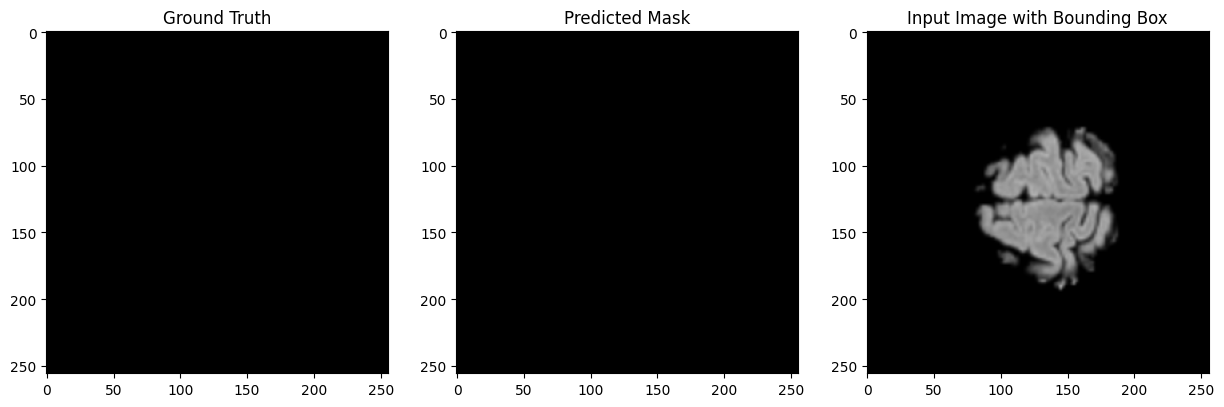

In [61]:
i,m = next(dataiter)
show_results(i,m,net,device, 0)

In [62]:
def calc_accuracy(test_dataloader, set_id, model, sample_num=None):
    batch_size = 1
    if not sample_num:
        N = len(test_dataloader)
    else:
        if sample_num <= 0:
            sample_num = len(test_dataloader)
        N = min(sample_num, len(test_dataloader))

    And = 0
    Uni = 0
    Uni_dice = 0

    T0 = 0
    T1 = 0
    F0 = 0
    F1 = 0

    for i, data in enumerate(test_dataloader, 0):
        #xx, yy, xs = data
        img, y = data

        # x0 = Variable(img0).to(device)
        # x1 = Variable(img1).to(device)
        # x2 = Variable(img2).to(device)
        # x3 = Variable(img3).to(device)
        # x4 = Variable(img4).to(device)
        img = img.to(device)
        yy = y.to(device)
        xx1 = net(img)
        xx1 = xx1.cpu().detach().numpy()
        yy = yy.cpu().detach().numpy()
        xx1[xx1 >= 0.5 ] = 1
        xx1[xx1 < 0.5 ] = 0

        owl = np.sum(xx1*yy)
        And += owl
        a_uni_dice = np.sum(xx1 + yy)
        a_uni = a_uni_dice - owl
        Uni += a_uni
        Uni_dice += a_uni_dice

        if xx1.max() == 0 and yy.max() == 0:
            T0 += 1
        if xx1.max() == 1 and yy.max() == 1:
            T1 += 1
        if xx1.max() == 0 and yy.max() == 1:
            F0 += 1
        if xx1.max() == 1 and yy.max() == 0:
            F1 += 1

        print('{}:  i = {}, And = {}, Uni = {}'.format(set_id, i, And, Uni))

        if i >= int(N - 1):
            break

    IoU_av = And / Uni if Uni > 0 else 0
    Dice = 2*And / Uni_dice if Uni_dice > 0 else 0

    return  IoU_av, Dice, T0, T1, F0, F1


In [63]:
IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr = calc_accuracy(test_dataloader1, 'train', net, sample_num=550)

train:  i = 0, And = 109.22352600097656, Uni = 180.77647399902344
train:  i = 1, And = 109.22352600097656, Uni = 210.77647399902344
train:  i = 2, And = 109.22352600097656, Uni = 210.77647399902344
train:  i = 3, And = 109.22352600097656, Uni = 210.77647399902344
train:  i = 4, And = 2362.521728515625, Uni = 3140.478271484375
train:  i = 5, And = 2452.760986328125, Uni = 3339.239013671875
train:  i = 6, And = 2452.760986328125, Uni = 3339.239013671875
train:  i = 7, And = 2452.760986328125, Uni = 3339.239013671875
train:  i = 8, And = 2799.05517578125, Uni = 3867.94482421875
train:  i = 9, And = 2988.011962890625, Uni = 4140.98779296875
train:  i = 10, And = 2988.011962890625, Uni = 4140.98779296875
train:  i = 11, And = 3086.79248046875, Uni = 4336.20751953125
train:  i = 12, And = 3104.78466796875, Uni = 4374.21533203125
train:  i = 13, And = 3104.78466796875, Uni = 4374.21533203125
train:  i = 14, And = 3104.78466796875, Uni = 4374.21533203125
train:  i = 15, And = 3104.78466796875,

In [64]:
print('training set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_tr, Dice_tr, T0_tr, T1_tr, F0_tr, F1_tr))

training set: IoU = 0.6545400619506836, Dice = 0.7912048697471619, True_0 = 267, True_1 = 272, False_0 = 7, False_1 = 4


In [65]:
IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts = calc_accuracy(test_dataloader2, 'test', net)

test:  i = 0, And = 0.0, Uni = 0.0
test:  i = 1, And = 0.0, Uni = 0.0
test:  i = 2, And = 0.0, Uni = 0.0
test:  i = 3, And = 0.0, Uni = 0.0
test:  i = 4, And = 0.0, Uni = 0.0
test:  i = 5, And = 0.0, Uni = 0.0
test:  i = 6, And = 0.0, Uni = 0.0
test:  i = 7, And = 0.0, Uni = 0.0
test:  i = 8, And = 0.0, Uni = 0.0
test:  i = 9, And = 0.0, Uni = 0.0
test:  i = 10, And = 0.0, Uni = 0.0
test:  i = 11, And = 0.0, Uni = 0.0
test:  i = 12, And = 0.0, Uni = 0.0
test:  i = 13, And = 0.0, Uni = 0.0
test:  i = 14, And = 0.0, Uni = 7.0
test:  i = 15, And = 0.0, Uni = 7.0
test:  i = 16, And = 0.0, Uni = 7.0
test:  i = 17, And = 0.0, Uni = 7.0
test:  i = 18, And = 0.0, Uni = 7.0
test:  i = 19, And = 0.0, Uni = 7.0
test:  i = 20, And = 0.0, Uni = 7.0
test:  i = 21, And = 0.0, Uni = 7.0
test:  i = 22, And = 0.0, Uni = 7.0
test:  i = 23, And = 0.0, Uni = 7.0
test:  i = 24, And = 0.0, Uni = 7.0
test:  i = 25, And = 0.0, Uni = 7.0
test:  i = 26, And = 0.0, Uni = 7.0
test:  i = 27, And = 0.0, Uni = 7.0
te

In [66]:
print('test set: IoU = {}, Dice = {}, True_0 = {}, True_1 = {}, False_0 = {}, False_1 = {}'.format(IoU_ts, Dice_ts, T0_ts, T1_ts, F0_ts, F1_ts))

test set: IoU = 0.6693662405014038, Dice = 0.8019405603408813, True_0 = 223, True_1 = 151, False_0 = 6, False_1 = 1
